In [1]:
import cv2
import os
from PIL import Image
import pandas as pd
from pandas import read_csv
import numpy as np

img_folder = "../Yoio_Park_Proof"
target_size = (512, 512)
label_data = read_csv("../local_data/balanced_labels_1.csv", sep=";")

'''
# Function to load and resize an image
def load_image(img_path, target_size):
    with Image.open(img_path) as img:
        img = img.resize(target_size)
        img = img.convert('RGB')  # Ensure image is in RGB format
        return np.array(img)
        '''

# Function to load, resize, and normalize an image using cv2
def load_image(img_path, target_size):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure image is in RGB format
        img = img / 255.0  # Normalize image to the range [0, 1]
    return img


# Read images and their corresponding labels
image_data = []
image_labels = []

for idx, row in label_data.iterrows():
    img_name = row['Image_name']
    img_path = os.path.join(img_folder, img_name)
    
    if os.path.exists(img_path):
        img_array = load_image(img_path, target_size)
        image_data.append(img_array)
        image_labels.append(row[1])  # Assuming labels are in columns after 'Image'
        print(f"Loaded image {img_name} with label {row[1]}", end='\r')
    else:
        print(f"Warning: Image {img_name} not found in folder {img_folder}")



/var/folders/qx/nn7p1qjs7xg_z1q9j7km_bv80000gn/T/ipykernel_11317/4118968486.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_labels.append(row[1])  # Assuming labels are in columns after 'Image'
/var/folders/qx/nn7p1qjs7xg_z1q9j7km_bv80000gn/T/ipykernel_11317/4118968486.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Loaded image {img_name} with label {row[1]}", end='\r')


In [2]:
label_data.describe()

,Rule1
count,297.000000
mean,0.387205
std,0.487933
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [4]:
from tensorflow.keras.utils import to_categorical
#normalize the images
#X_train = np.array(X_train)/255.0
y_train = to_categorical(y_train, num_classes=2)
#X_test = np.array(X_test)/255.0
y_test = to_categorical(y_test, num_classes=2)

In [5]:
import pickle

with open('../local_data/test_img_1.pickle', 'wb') as f:
    pickle.dump((X_test, y_test), f)

In [6]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    horizontal_flip=True,
)

In [7]:
#generate augmented images
image_num = 2200 - len(X_train)
augmented_images = []
augmented_labels = []
generated_count = 0


for batch in datagen.flow(X_train, y_train, batch_size=1):
  augmented_images.append(batch[0])
  augmented_labels.append(batch[1])
  generated_count += batch[0].shape[0]
  print("Generated ", generated_count, " augmented images", end='\r')
  if generated_count >= image_num:
    print("Generating done, generated", image_num, " augmented images")
    break

Generating done, generated 1963  augmented images


In [8]:
augmented_images = np.array(augmented_images).reshape(-1, 512, 512, 3)
augmented_labels = np.array(augmented_labels).reshape(-1, 2)

augmented_images.shape, augmented_labels.shape

((1963, 512, 512, 3), (1963, 2))

In [9]:
#add x_train and augmented images together
augmented_images = np.concatenate((X_train, np.array(augmented_images)))
augmented_labels = np.concatenate((y_train, np.array(augmented_labels)))

In [10]:
import pickle

with open('../local_data/data_useable_1.pickle', 'wb') as f:
    pickle.dump((augmented_images, augmented_labels), f)

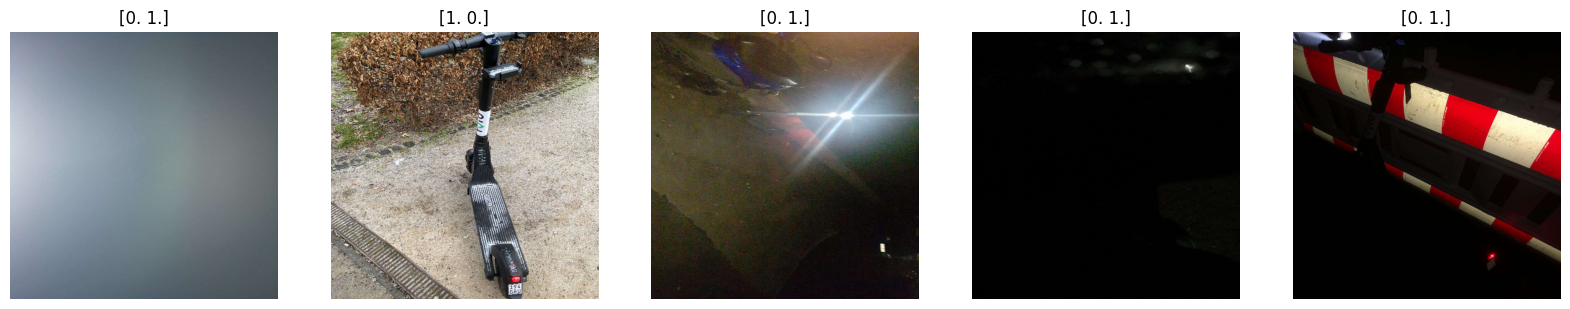

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    #axes[i].imshow(augmented_images[i].astype('uint8'))
    axes[i].imshow(augmented_images[i])
    axes[i].set_title(augmented_labels[i])
    axes[i].axis('off')
plt.show()